In [1]:
%load_ext autoreload
%autoreload 2

# Добавляем путь к основной папке проекта, чтобы иметь возможность делать импорт из src
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import catboost

In [3]:
data = pd.read_csv('../data/classification_dataset.csv')
print(data.shape)
data.head()

(459050, 17)


,tx_hash,current_block,timestamp,status,availablePriorityFee,gas,already_waiting,baseFeePerGas,previousBlockGasUsed,is_ofac,included,priority_n,total_eligible_txs,priority_percent,cumulative_gas,first_gas_unit,last_gas_unit
0,0x36a8f87e6be412d5d3ef5c774e221e610b5c8871463b...,16221292,1671483623,ok,1092.697098,175920,1.0,18.302902,22334900,False,next_block,0,346,0.000000,175920,0.000000,0.005864
1,0x1be4691644fd620612a44c306341d3e4e5c4486ada4e...,16221292,1671483623,ok,686.697098,175920,4.0,18.302902,22334900,False,now,1,346,0.002890,351840,0.005864,0.011728
2,0xe67a86403cbe1dd893b764c49bdc86d821fcbd81d996...,16221292,1671483623,ok,599.000000,175920,2.0,18.302902,22334900,False,next_block,2,346,0.005780,527760,0.011728,0.017592
3,0x98afadc301f16fb299311247444e77a422dbf35deddf...,16221292,1671483623,ok,511.000000,175920,5.0,18.302902,22334900,False,now,3,346,0.008671,703680,0.017592,0.023456
4,0x9ec221ab70707257d9343329a607667624423144b046...,16221292,1671483623,ok,444.000000,175920,2.0,18.302902,22334900,False,next_block,4,346,0.011561,879600,0.023456,0.029320


In [4]:
# Всего блоков в датасете

data['current_block'].nunique()

2200

In [5]:
# Последние 350 блоков из 

valid_blocks = sorted(data['current_block'].unique())[-350:]

In [6]:
# Выставим target

data['target'] = 0
data.loc[data['included'] == 'now', 'target'] = 1

In [7]:
data['target'].value_counts()

1    334045
0    125005
Name: target, dtype: int64

In [8]:
from catboost import CatBoostClassifier

In [10]:
# feature_columns = ['availablePriorityFee', 'gas', 'already_waiting', 'baseFeePerGas',
#                    'previousBlockGasUsed', 'priority_n',
#                    'total_eligible_txs', 'priority_percent', 'cumulative_gas',
#                    'first_gas_unit', 'last_gas_unit']

feature_columns = ['availablePriorityFee','already_waiting', 'baseFeePerGas',
                   'previousBlockGasUsed']

In [11]:
data_non_ofac = data[~data['is_ofac']].copy()
data_ofac = data[data['is_ofac']].copy()

In [12]:
train_data = data_non_ofac[~data_non_ofac['current_block'].isin(valid_blocks)].copy()
valid_data = data_non_ofac[data_non_ofac['current_block'].isin(valid_blocks)].copy()

In [13]:
X_train = train_data[feature_columns].copy()
y_train = train_data['target'].copy()

X_valid = valid_data[feature_columns].copy()
y_valid = valid_data['target'].copy()

In [14]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_valid), y=y_valid)
class_weights

array([1.51590387, 0.74608628])

In [15]:
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.01,
    class_weights=class_weights
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    # cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=100
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 0.6792070	test: 0.6770595	best: 0.6770595 (0)	total: 64.4ms	remaining: 1m 36s
100:	learn: 0.3145504	test: 0.2790725	best: 0.2790725 (100)	total: 1.3s	remaining: 18s
200:	learn: 0.2786941	test: 0.2505742	best: 0.2505742 (200)	total: 2.46s	remaining: 15.9s
300:	learn: 0.2672777	test: 0.2469139	best: 0.2468418 (295)	total: 3.62s	remaining: 14.4s
400:	learn: 0.2598111	test: 0.2468515	best: 0.2462906 (356)	total: 4.82s	remaining: 13.2s
500:	learn: 0.2543339	test: 0.2472395	best: 0.2462906 (356)	total: 6.02s	remaining: 12s
600:	learn: 0.2491966	test: 0.2475804	best: 0.2462906 (356)	total: 7.18s	remaining: 10.7s
700:	learn: 0.2446148	test: 0.2479395	best: 0.2462906 (356)	total: 8.31s	remaining: 9.47s
800:	learn: 0.2401556	test: 0.2480482	best: 0.2462906 (356)	total: 9.45s	remaining: 8.25s
900:	learn: 0.2361011	test: 0.2484490	best: 0.2462906 (356)	total: 10.6s	remaining: 7.03s
1000:	learn: 0.2321885	test: 0.2490944	best: 0.2462906 (356)	total: 11.7s	remaining: 5.85s
1100:	learn: 0.2

In [16]:
pred = model.predict(X_valid)

In [17]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [18]:
print(f'Precision {precision_score(y_valid, pred):0.3f}')
print(f'Recall {recall_score(y_valid, pred):0.3f}')
print(f'F1 {f1_score(y_valid, pred):0.3f}')

Precision 0.921
Recall 0.986
F1 0.952


In [19]:
ofac_feats = data_ofac[feature_columns].copy()
ofac_target = data_ofac['target'].copy()
ofac_pred = model.predict(ofac_feats)

print(f'Precision {precision_score(ofac_target, ofac_pred):0.3f}')
print(f'Recall {recall_score(ofac_target, ofac_pred):0.3f}')
print(f'F1 {f1_score(ofac_target, ofac_pred):0.3f}')

Precision 0.456
Recall 0.898
F1 0.604


In [20]:
feature_imp = sorted(zip(feature_columns, model.get_feature_importance()), key=lambda x:x[1], reverse=True)

for col, imp in feature_imp:
    print(f'{col} - {imp:0.5f}')

already_waiting - 75.50752
availablePriorityFee - 9.12073
previousBlockGasUsed - 8.21792
baseFeePerGas - 7.15383


In [21]:
pred_proba = model.predict_proba(X_valid)

In [22]:
from sklearn.calibration import calibration_curve

In [23]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_valid, pred_proba[:, 1], n_bins=20)

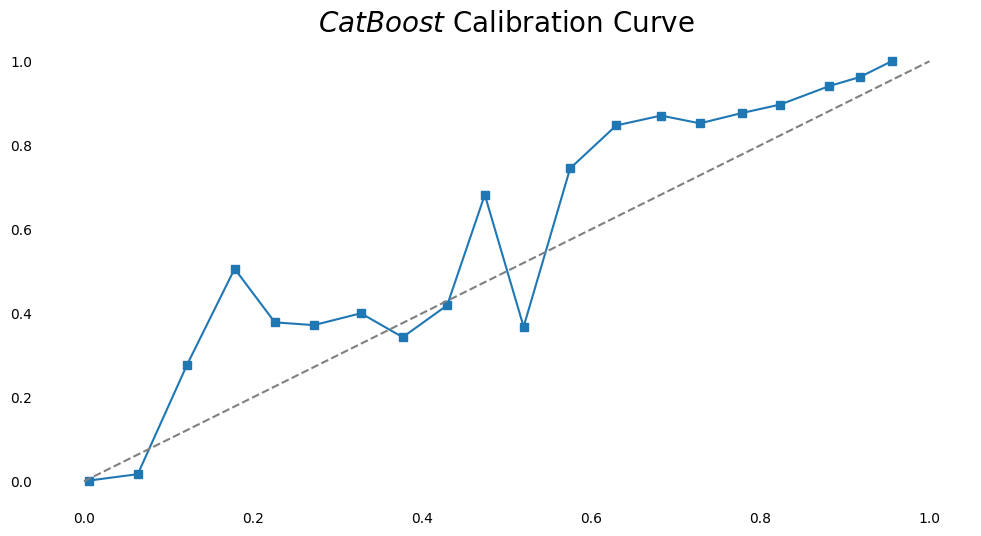

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$CatBoost$ Calibration Curve", fontsize=20); pass

In [25]:
from sklearn.calibration import CalibratedClassifierCV

clf_sigmoid = CalibratedClassifierCV(CatBoostClassifier(iterations=1500,
                                                        learning_rate=0.01,
                                                        class_weights=class_weights),
                                     cv=5, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)

0:	learn: 0.6797986	total: 13.8ms	remaining: 20.6s
1:	learn: 0.6677285	total: 27.8ms	remaining: 20.8s
2:	learn: 0.6542590	total: 37.5ms	remaining: 18.7s
3:	learn: 0.6428447	total: 45.7ms	remaining: 17.1s
4:	learn: 0.6312877	total: 55.5ms	remaining: 16.6s
5:	learn: 0.6186332	total: 64.9ms	remaining: 16.2s
6:	learn: 0.6074875	total: 74.7ms	remaining: 15.9s
7:	learn: 0.5961449	total: 83.3ms	remaining: 15.5s
8:	learn: 0.5854463	total: 93.7ms	remaining: 15.5s
9:	learn: 0.5744146	total: 104ms	remaining: 15.5s
10:	learn: 0.5661371	total: 113ms	remaining: 15.2s
11:	learn: 0.5570496	total: 122ms	remaining: 15.1s
12:	learn: 0.5472739	total: 131ms	remaining: 14.9s
13:	learn: 0.5384951	total: 140ms	remaining: 14.9s
14:	learn: 0.5291980	total: 149ms	remaining: 14.8s
15:	learn: 0.5213252	total: 158ms	remaining: 14.7s
16:	learn: 0.5141465	total: 167ms	remaining: 14.6s
17:	learn: 0.5067508	total: 176ms	remaining: 14.5s
18:	learn: 0.4995238	total: 185ms	remaining: 14.4s
19:	learn: 0.4935010	total: 193m

CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x7f6c17ac3940>)

In [26]:
clf_isotonic = CalibratedClassifierCV(CatBoostClassifier(iterations=1500,
                                                        learning_rate=0.01,
                                                        class_weights=class_weights),
                                     cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train)

0:	learn: 0.6797986	total: 11.7ms	remaining: 17.5s
1:	learn: 0.6677285	total: 22.5ms	remaining: 16.9s
2:	learn: 0.6542590	total: 31.8ms	remaining: 15.8s
3:	learn: 0.6428447	total: 40.1ms	remaining: 15s
4:	learn: 0.6312877	total: 49.7ms	remaining: 14.9s
5:	learn: 0.6186332	total: 59ms	remaining: 14.7s
6:	learn: 0.6074875	total: 68.9ms	remaining: 14.7s
7:	learn: 0.5961449	total: 78.3ms	remaining: 14.6s
8:	learn: 0.5854463	total: 87.8ms	remaining: 14.6s
9:	learn: 0.5744146	total: 97.2ms	remaining: 14.5s
10:	learn: 0.5661371	total: 106ms	remaining: 14.4s
11:	learn: 0.5570496	total: 115ms	remaining: 14.3s
12:	learn: 0.5472739	total: 124ms	remaining: 14.2s
13:	learn: 0.5384951	total: 134ms	remaining: 14.2s
14:	learn: 0.5291980	total: 143ms	remaining: 14.2s
15:	learn: 0.5213252	total: 152ms	remaining: 14.1s
16:	learn: 0.5141465	total: 161ms	remaining: 14.1s
17:	learn: 0.5067508	total: 170ms	remaining: 14s
18:	learn: 0.4995238	total: 180ms	remaining: 14s
19:	learn: 0.4935010	total: 189ms	remai

CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x7f6c15dcb910>,
                       method='isotonic')

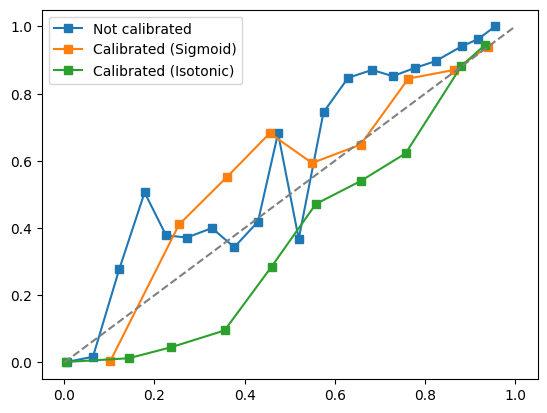

In [27]:
y_valid_predict_proba_sigmoid = clf_sigmoid.predict_proba(X_valid)[:, 1]
fraction_of_positives_sigmoid, mean_predicted_value_sigmoid = calibration_curve(y_valid, y_valid_predict_proba_sigmoid, n_bins=10)

y_valid_predict_proba_isotonic = clf_isotonic.predict_proba(X_valid)[:, 1]
fraction_of_positives_isotonic, mean_predicted_value_isotonic = calibration_curve(y_valid, y_valid_predict_proba_isotonic, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Not calibrated')
plt.plot(mean_predicted_value_sigmoid, fraction_of_positives_sigmoid, 's-', label='Calibrated (Sigmoid)')
plt.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, 's-', label='Calibrated (Isotonic)')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend()

In [28]:
# Base model

print(f'Precision {precision_score(y_valid, pred):0.3f}')
print(f'Recall {recall_score(y_valid, pred):0.3f}')
print(f'F1 {f1_score(y_valid, pred):0.3f}')

Precision 0.921
Recall 0.986
F1 0.952


In [29]:
# Sigmoid calibrated
pred_sigmoid = clf_sigmoid.predict(X_valid)

print(f'Precision {precision_score(y_valid, pred_sigmoid):0.3f}')
print(f'Recall {recall_score(y_valid, pred_sigmoid):0.3f}')
print(f'F1 {f1_score(y_valid, pred_sigmoid):0.3f}')

Precision 0.918
Recall 0.989
F1 0.952


In [30]:
# Isotonic calibrated
pred_isotonic = clf_isotonic.predict(X_valid)

print(f'Precision {precision_score(y_valid, pred_isotonic):0.3f}')
print(f'Recall {recall_score(y_valid, pred_isotonic):0.3f}')
print(f'F1 {f1_score(y_valid, pred_isotonic):0.3f}')

Precision 0.912
Recall 0.997
F1 0.953
